<a href="https://colab.research.google.com/github/taasinsaquib/retina/blob/main/onv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/thesis_stuff/'

/content/drive/MyDrive/thesis_stuff


In [3]:
! pip install livelossplot torchinfo --quiet

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from   torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torchvision
from   torchvision import transforms, utils
from   torchinfo   import summary

import time
import copy
import sys

# specific package for visualization
from livelossplot import PlotLosses

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
seed = 28

# ONV has 14400 photoreceptors, reshape to a square for RESNET
w = 120
h = 120

# Data

## Combine and Shuffle Collected Data

In [12]:
sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
types = ['L', 'R']

In [13]:
data   = None
labels = None

for s in sizes:
  for t in types:

    d = np.load(f'./retina_LR/data_dist_{s}_{t}.npy')
    l = np.load(f'./retina_LR/labels_dist_{s}_{t}.npy')

    if data is None:
      data   = d
      labels = l
  
    else:
      data   = np.vstack((data, d))
      labels = np.vstack((labels, l))

In [14]:
shuffler = np.random.RandomState(seed=seed).permutation(len(labels))

data_shuffled   = data[shuffler]
labels_shuffled = labels[shuffler]

np.save('./retina_LR/data_combined',   data_shuffled)
np.save('./retina_LR/labels_combined', labels_shuffled)

## Load Combined Data

In [7]:
data   = np.load('./retina_LR/data_combined.npy')
labels = np.load('./retina_LR/labels_combined.npy')
print(data.shape, labels.shape)

(4080, 14400) (4080, 3)


##Create Torch Datasets (Loaders)

In [8]:
class ONVData(Dataset):

    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index):

        x, y = self.subset[index]

        # ResNET 2 channels

        # TODO: make square 120x120
        x = np.resize(x, (w, h))

        posIdx = np.where(x == 1)
        negIdx = np.where(x == -1)

        channel1 = channel2 = np.zeros((w, h))
        newData = np.zeros((2, w, h), dtype=np.float)

        newData[0][posIdx] = 1
        newData[1][negIdx] = -1

        # print(type(x))
        x = torch.from_numpy(newData)
        # print(type(x))

        if self.transform:
          x = self.transform(x)

        return x, y

In [9]:
X_data_tensor = torch.from_numpy(data).float()
y_data_tensor = torch.from_numpy(labels).float()
init_dataset = TensorDataset(X_data_tensor, y_data_tensor)

In [10]:
# split train, val, test
lengths = np.array([0.7, 0.1, 0.2])
lengths *= int(len(init_dataset))
lengths = np.rint(lengths)
lengths = np.asarray(lengths, dtype=np.int32)

# lengths[1] += 1

In [11]:
print(lengths, np.sum(lengths), len(init_dataset))

[2856  408  816] 4080 4080


In [12]:
subset_train, subset_val, subset_test = random_split(init_dataset, lengths, generator=torch.Generator().manual_seed(seed)) 

train_data = ONVData(
    subset_train, transform=None)

val_data = ONVData(
    subset_val, transform=None)

test_data = ONVData(
    subset_test, transform=None)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,  num_workers=1),
    'val':   torch.utils.data.DataLoader(val_data,   batch_size=8,  shuffle=False, num_workers=1),
    'test':  torch.utils.data.DataLoader(test_data,  batch_size=8,  shuffle=False, num_workers=1),
}

# Training Helpers

In [13]:
def train_model(model, optimizer, num_epochs):
    # for each epoch... 
    liveloss = PlotLosses()

    best_model = None
    highest_val = 0

    for epoch in range(num_epochs):
      print('Training Model: ', model.__class__.__name__)
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      logs = {}

      # let every epoch go through one training cycle and one validation cycle
      # TRAINING AND THEN VALIDATION LOOP...
      for phase in ['train', 'val']:
        train_loss = 0
        correct = 0
        total = 0
        batch_idx = 0

        start_time = time.time()
        # first loop is training, second loop through is validation
        # this conditional section picks out either a train mode or validation mode
        # depending on where we are in the overall training process
        # SELECT PROPER MODE- train or val
        if phase == 'train':
          for param_group in optimizer.param_groups:
            print("LR", param_group['lr']) # print out the learning rate
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode
        
        for inputs, labels in dataloaders[phase]:

          inputs = inputs.float()
          labels = labels.float()

          inputs = inputs.to(device)
          labels = labels.to(device)

          batch_idx += 1
          
          optimizer.zero_grad()
          
          with torch.set_grad_enabled(phase == 'train'):
            #    the above line says to disable gradient tracking for validation
            #    which makes sense since the model is in evluation mode and we 
            #    don't want to track gradients for validation)  
            outputs = model(inputs)

            # print("1", outputs.type())
            # print("2", labels.type())

            # compute loss where the loss function will be defined later
            loss = loss_fn(outputs, labels)

            # print("3", loss.type())

            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

            train_loss += loss

            c, t = numVectorsMatch(outputs, labels, atol=0.25)

            correct += c
            total   += t

            print(correct, total)

        # if phase == 'train':
        #   if  epoch%5 == 0:
        #   # prints for training and then validation (since the network will be in either train or eval mode at this point) 
        #     print(" Training Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        # if phase == 'val' and epoch%5 == 0:
        #   print(" Validation Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        prefix = ''
        if phase == 'val':
            prefix = 'val_'
            # tune.track.log(mean_accuracy=correct/total)

            if (correct/total) > highest_val:
              print('Best val till now: ', (correct/total))
              highest_val = (correct/total)
              # logs['what'] = highest_val
              best_model = copy.deepcopy(model)

        logs[prefix + 'loss'] = train_loss.item()/(batch_idx)
        logs[prefix + 'acc'] = (correct / total) * 100

      liveloss.update(logs)
      liveloss.send()

    # end of single epoch iteration... repeat of n epochs  
    return best_model, model

In [14]:
def test_model(model):

  total = correct = 0

  for inputs, labels in dataloaders['test']:

    inputs = inputs.float()
    labels = labels.float()

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    c, t = numVectorsMatch(outputs, labels, atol=0.25)
    correct += c
    total   += t

  return (correct/total) * 100

In [15]:
def numVectorsMatch(outputs, labels, rtol = 0, atol = 0.5):

  correct = 0
  total   = labels.size(0)

  # print("0")

  # rounding with torch
  # n_digits = 2
  # https://discuss.pytorch.org/t/round-tensor-to-x-decimal-places/25832
  # labels = torch.round(labels * 10**n_digits) / (10**n_digits)
  # outputs = torch.round(outputs * 10**n_digits) / (10**n_digits)

  # print("1")
  close = torch.isclose(outputs, labels, rtol, atol)
  # print("2", close.size)
  for r in close:
    if torch.sum(r == True) == 3:
      correct += 1
  # print("3")
  # for i in range(0, len(outputs)):
    # if torch.allclose(outputs[i], labels[i], rtol, atol):
      # correct += 1
      # print(outputs[i], labels[i])

  return correct, total

# Models

## ANNs

In [ ]:
class ANN1(nn.Module):
  def __init__(self):
    super(ANN1, self).__init__()

    self.fc1 = nn.Linear(w*h, 1000)
    self.fc2 = nn.Linear(1000, 100)
    self.fc3 = nn.Linear(100, 3)

  def forward(self, x):

    x = x.view(-1, w*h)

    # print(x.shape)

    x = self.fc1(x)
    x = torch.relu(x)

    x = self.fc2(x)
    x = torch.relu(x)

    x = self.fc3(x)

    return x

## ResNET Experiment

In [16]:
class MyResNet(nn.Module):
  def __init__(self, pretrained):
    super(MyResNet, self).__init__()
    
    self.pretrained = pretrained
    self.input = nn.Conv2d(2, 3, (2, 4280), stride=1, padding='same')

  def forward(self, x):

    # print(x.shape)

    x = self.input(x)

    # print(x.shape)

    x = self.pretrained(x)

    # print((x).type())

    return x

In [17]:
modResnet = torchvision.models.resnet18(pretrained=True)

for param in modResnet.parameters():
    param.requires_grad = False

modResnet.fc = nn.Linear(512, 3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [18]:
summary(modResnet, input_size=(32, 3, w, h))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [32, 64, 60, 60]          (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 60, 60]          (128)
├─ReLU: 1-3                              [32, 64, 60, 60]          --
├─MaxPool2d: 1-4                         [32, 64, 30, 30]          --
├─Sequential: 1-5                        [32, 64, 30, 30]          --
│    └─BasicBlock: 2-1                   [32, 64, 30, 30]          --
│    │    └─Conv2d: 3-1                  [32, 64, 30, 30]          (36,864)
│    │    └─BatchNorm2d: 3-2             [32, 64, 30, 30]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 30, 30]          --
│    │    └─Conv2d: 3-4                  [32, 64, 30, 30]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 30, 30]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 30, 30]  

# Train

In [19]:
loss_fn = nn.MSELoss()

In [20]:
def pipeline(model, lr=1e-2, weight_decay=0.1, epochs=25):
  
  opt = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)
  
  best_model, m = train_model(model, opt, num_epochs=epochs)

  return best_model, m

## ResNET experiment \#1
* got _v2 to 78% accuracy
  * TODO: need to make vector comparison margin tighter, like 0.1
* inference works sometimes, better when in middle of retina
  * polarity sometimes switches
* can't generalize well to odd movement since data is all even
  * TODO: collect more of this


In [ ]:
model = MyResNet(modResnet)
model.float()
model.to(device)

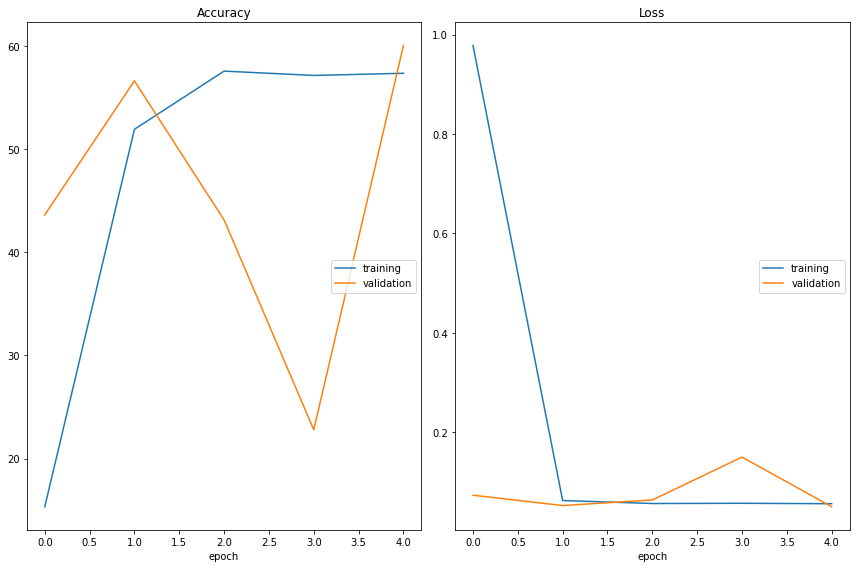

Accuracy
	training         	 (min:   15.336, max:   57.563, cur:   57.353)
	validation       	 (min:   22.794, max:   60.049, cur:   60.049)
Loss
	training         	 (min:    0.057, max:    0.978, cur:    0.057)
	validation       	 (min:    0.050, max:    0.150, cur:    0.050)


In [22]:
best, last = pipeline(model, epochs=5)

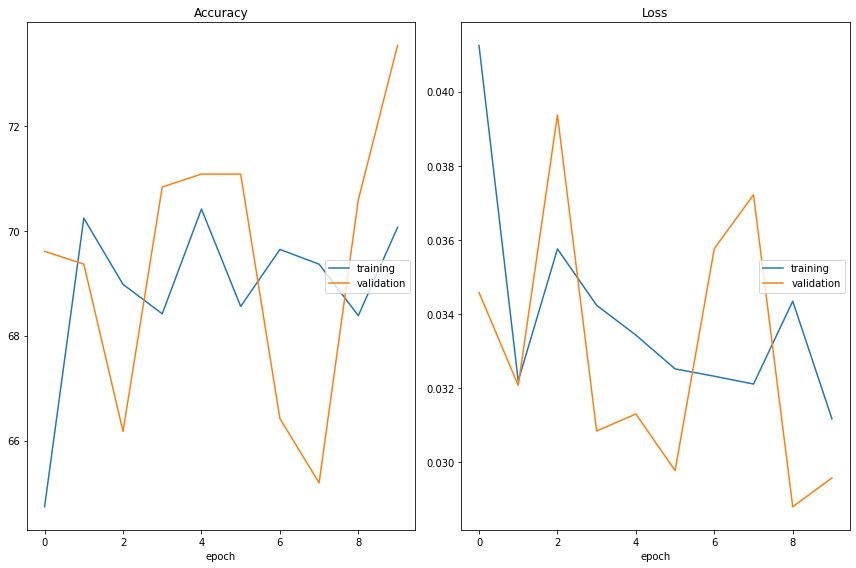

Accuracy
	training         	 (min:   64.741, max:   70.413, cur:   70.063)
	validation       	 (min:   65.196, max:   73.529, cur:   73.529)
Loss
	training         	 (min:    0.031, max:    0.041, cur:    0.031)
	validation       	 (min:    0.029, max:    0.039, cur:    0.030)


In [49]:
best, last = pipeline(best, epochs=10, lr=1e-3)

In [50]:
best.eval()
acc = test_model(best)
print(acc)

71.56862745098039


In [46]:
 torch.save(best, 'onv_resnet_v2')
 torch.save(best.state_dict(), 'onv_resnet_v2_dict')

In [ ]:
m = torch.load('./onv_resnet_v2')